# Academic success in high schools: What drives differences in SAT-scores across NYC?

## Goal

The results of the standardized "SAT"-exam is used by US-colleges to determine which high school graduates they admit.
We want to know which factors may drive differences in SAT-scores, if there are any pattern, trends or reasons discriminating against certain groups of students.

# [ETL] Reading data

In [1]:
# standard libs and additional utilities
from tqdm.notebook import tqdm_notebook # progress bar for timeconsuming geocoding
import tqdm
import warnings  # used here to surpress FutureWarning
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py  # interactive plotting
import plotly.graph_objs as go
import cufflinks as cf  # interactive plotting made easy (pandas style)

# Using plotly + cufflinks in offline mode
from plotly.offline import iplot, init_notebook_mode
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

# jupyter command to show plots in notebook
%matplotlib inline

# setting pandas display options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
pd.set_option('max_colwidth', 50)

# read seperate input files into single dictionary
# csv-files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    name=f.split(".")[0]
    d = pd.read_csv("schools/{0}".format(f))
    data[name]=d
    
# survey data, different format
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=True)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [2]:
for k in data.keys():
    s=data[k].shape
    print(k, s)

ap_2010 (258, 5)
class_size (27611, 16)
demographics (10075, 38)
graduation (25096, 23)
hs_directory (435, 58)
sat_results (478, 6)
survey (1702, 23)


# [ETL] Adding and converting features

In [3]:
# add DBN columns as unique identifier in datasets where they are not yet present
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
def pad_csd(element):
    element=str(element)
    return element.zfill(2)
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# summing SAT-score
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# extracting latitude and longitude to separate columns
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# convert latitude and longitude to numeric
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

print(data['sat_results']['sat_score'].head())
print("\n")
print(data["hs_directory"]["lat"].head())
print("\n")
print(data["hs_directory"]["lon"].head())

0   1,122.000
1   1,172.000
2   1,149.000
3   1,174.000
4   1,207.000
Name: sat_score, dtype: float64


0   40.670
1   40.828
2   40.842
3   40.711
4   40.719
Name: lat, dtype: float64


0   -73.962
1   -73.904
2   -73.916
3   -74.001
4   -73.807
Name: lon, dtype: float64


# [ETL] Condensing and combining datasets

In [4]:
# selecting the classes relevant for SAT-analysis (high school, general education)
class_size=data["class_size"]
filter=(class_size["GRADE "]=='09-12') & (class_size['PROGRAM TYPE']=='GEN ED')
class_size=class_size[filter]

# compute average class size by school across all subjects
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# select most recent data available in "demographics" and "graduation" dataset
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data["graduation"]=data['graduation'][(data['graduation']['Cohort']=='2006') & (data['graduation']['Demographic']=='Total Cohort')]

# initiate combined dataset with our main variable we want to investigate
combined = data["sat_results"]

# left joins for somewhat sparse datasets, because we do not want to loose any SAT-info
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# inner joins for other dataset that potentially contain very relevant explanatory features.
# if these features are not available for a high school, our we want to exclude these schools
to_merge = ["class_size", "demographics", "survey", "hs_directory"]
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# missing values for numeric columns filled with mean, non-numerics with zeros 
combined = combined.fillna(combined.mean()) # potential lever to improve quality of analysis, not scope of this learning exercise
combined = combined.fillna(0)

# Add a school district column for later analysis
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)
combined["school_dist"].head()

print(combined.shape)

(363, 160)


# Find correlations with SAT scores

In [6]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score    0.987
SAT Math Avg. Score                0.973
SAT Writing Avg. Score             0.988
sat_score                          1.000
AP Test Takers                     0.523
                                   ...  
priority08                           nan
priority09                           nan
priority10                           nan
lat                               -0.121
lon                               -0.132
Name: sat_score, Length: 67, dtype: float64

# Plotting survey correlations: Safety and students expectations are important

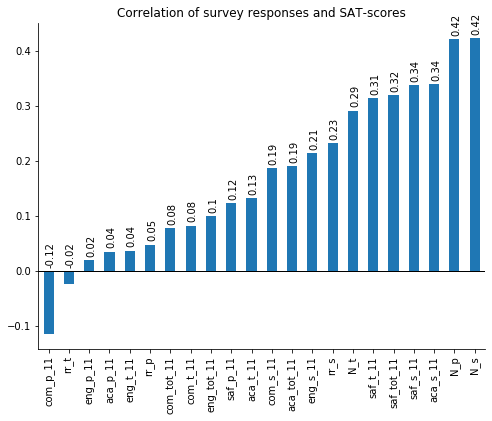

In [7]:
survey_fields=['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

# compute all correlations with SAT scores
correlations = combined.corr()

# build a barchart to visualize SAT and survey response correlation  
surv_corr = correlations.loc[survey_fields]['sat_score'].sort_values()
ax=surv_corr.plot(kind="bar", figsize=(8, 6), title="Correlation of survey responses and SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x()+0.1, max(p.get_height(), 0)+0.01),
                rotation=90
                )
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

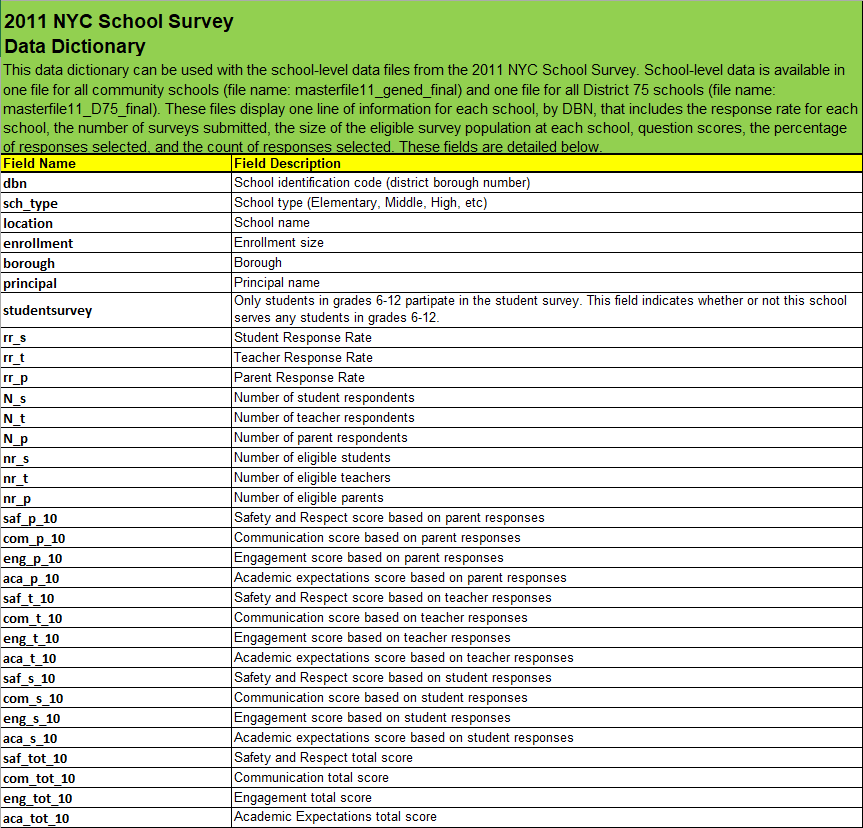

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

We can also notice that Safety and Respect scores based on teachers and students responses are strong positive correlated with `sat_score`, that means that the higher SAT score have schools where safety and respect to each other are important indicators, that can generally point on good schools from good districts.

The next interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, it makes sense when student's academic expectations play important role for him then the student highly likely will doing well his academic, but this is not true for `aca_t_11` and `aca_p_11`, how teachers and parents perceive academic standards.

#  Missing safety in the Bronx and Brooklyn does not allow to get high SAT-scores

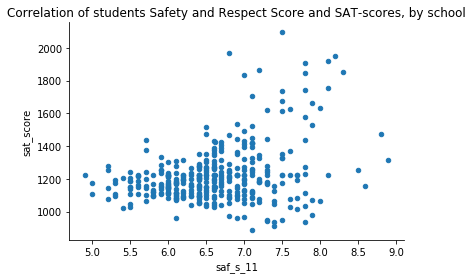

In [8]:
# build a scatter plot to visualize correlation between SAT and Safety and Respect Rating (students)
ax=combined.plot(kind="scatter", x='saf_s_11', y='sat_score', figsize=(6, 4), 
                 title="Correlation of students Safety and Respect Score and SAT-scores, by school")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

We can notice that for majority schools with SAT scores between 1000 and 1400, safety scores generally are in range 5-7, schools with safety scores above 7 have as the high SAT scores as well as low SAT score under the 1000.

In [9]:
# avg. student safety grouped by districts
import numpy as np
grouped=combined.groupby('school_dist')
by_district=grouped.agg(np.mean)
by_district.reset_index(inplace=True)

New York districts map:

https://i.imgur.com/0nv55lt.png
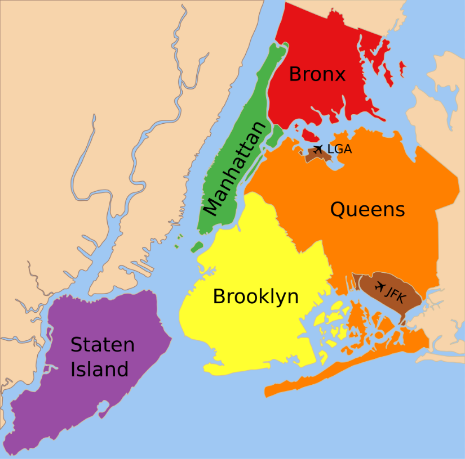

In [10]:
# code for map
import folium
import branca.colormap as cm

# set a simple baselayer and zoom-in on NY
school_map = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=10,
                        tiles='CartoDB positron')

# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "NY highschools: avg. safety / respect score and avg. enrollment by school district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

# select column names of the viz parameters
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = by_district[color_parameter].min()
end_col_val = by_district[color_parameter].max()
start_col_hex = "#2c7fb8" # used https://colorbrewer2.org/ 
end_col_hex = "#edf8b1"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     #"white",
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety / Respect Score, students response"

# create a circle for each school district
for index, row in by_district.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)

# add a legend
school_map.add_child(colormap)
    
# display the map
school_map

Above method discribes in yellow the schools with a high `saf_s_11`, and schools with a low `saf_s_11` are blue. 

We can see, that the schools with high safety scores are mainly from Manhattan, north-west Queens and parts from south Brooklyn, schools with low safety scores are from north Brooklyn, parts of Bronx and east Queens.

In [11]:
low_sat_dist=by_district[by_district["sat_score"]<1200]
# code for map
import folium
import branca.colormap as cm

# set a simple baselayer and zoom-in on NY
school_map = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=10,
                        tiles='CartoDB positron')

# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "NY highschools: avg. safety / respect score for schools with low SAT scores by district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

# select column names of the viz parameters
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = low_sat_dist[color_parameter].min()
end_col_val = low_sat_dist[color_parameter].max()
start_col_hex = "#2c7fb8" # used https://colorbrewer2.org/ 
end_col_hex = "#edf8b1"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     #"white",
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety / Respect Score, students response"

# create a circle for each school district
for index, row in low_sat_dist.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)

# add a legend
school_map.add_child(colormap)
    
# display the map
school_map

Above there are all schools with low SAT scores (under 1200), accordingly low safety scores are in north Brooklyn, but Bronx district is  diversified where near the schools with safe enveroment are schools with missing safety.

In [12]:
high_sat_dist=by_district[by_district["sat_score"]>1300]
# code for map
import folium
import branca.colormap as cm

# set a simple baselayer and zoom-in on NY
school_map = folium.Map(location=[40.693943, -73.985880], 
                        #width=500,
                        #height=800,
                        zoom_start=10,
                        tiles='CartoDB positron')

# generate a title above the map
# from https://github.com/python-visualization/folium/issues/1202
map_title = "NY highschools: avg. safety / respect score for schools with high SAT scores by district"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

# select column names of the viz parameters
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = high_sat_dist[color_parameter].min()
end_col_val = high_sat_dist[color_parameter].max()
start_col_hex = "#2c7fb8" # used https://colorbrewer2.org/ 
end_col_hex = "#edf8b1"
colormap = cm.LinearColormap(colors=[start_col_hex,
                                     #"white",
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety / Respect Score, students response"

# create a circle for each school district
for index, row in high_sat_dist.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)

# add a legend
school_map.add_child(colormap)
    
# display the map
school_map

Here there is a plotting for schools with high SAT scores (above 1300) and it appears that majority schools with high SAT and high safety scores are from north Queens and from south Brooklyn.

# Race: Hispanics and blacks disadvantaged

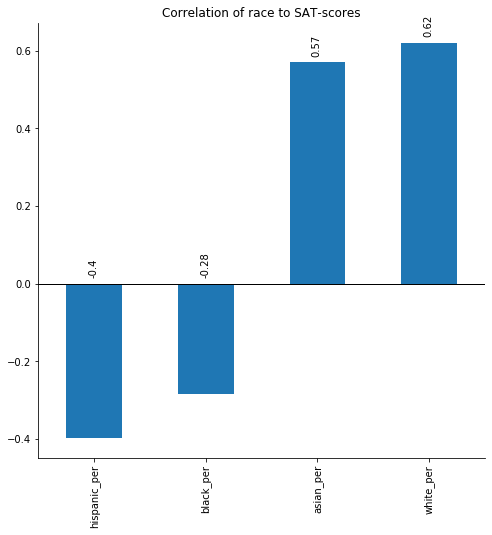

In [13]:
race_corr = correlations.loc[['white_per', 'asian_per', 'black_per', 'hispanic_per']]['sat_score'].sort_values()
ax=race_corr.plot(kind='bar', figsize=(8, 8), title="Correlation of race to SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for p in ax.patches: # set data point labels
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + 0.2, max(p.get_height(), 0)+0.02),
                rotation=90
                )
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

We can notice certain correlation between SAT scores and race percentage, the higher there is percent of white and asian students in the school, the higher SAT score the school has and opposite for black and hispanic races, the lower is percentage for them the higher the SAT score is.

In [14]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='hispanic_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["hispanic_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share hispanics, %',
        yTitle='Avg. SAT score',
        title='Share of hispanic students vs. SAT score by school <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


Above plot confirms that majority of schools have SAT scores under 1400 with wide range of hispanic students percent - up to 60%, but there is group of schools with high SAT scores where `hispanic_per` is no more than 25% and there are schools with more than 80% of hispanic students which have low SAT under 1200, that contributes to the evident down trend, the higher is `hispanic_per`, the lower is SAT scores.

In [15]:
combined.loc[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [16]:
# create school_type field defining all schools vs. elite schools (SAT score > 1,800)
num_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']
combined['school_type']='All schools'
high_rate=combined['sat_score']>1800
combined.loc[high_rate, 'school_type']='Elite schools'

# create racial distribution df
elit_filtr=combined['school_type']=='Elite schools'
elit=(combined.loc[elit_filtr, num_race].sum()/combined.loc[elit_filtr, num_race].sum().sum())*100
all=(combined.loc[:, num_race].sum()/combined.loc[:, num_race].sum().sum())*100
race_dist = pd.DataFrame(data=[elit,all],index=["Elite schools", "All schools"])
race_dist.columns = ["Asian","Black","Hispanic", "White"]
race_dist

,Asian,Black,Hispanic,White
Elite schools,58.317,6.433,7.824,27.425
All schools,17.248,30.051,38.798,13.903


In [17]:
# build stacked bar to racial makeup of all schools and elite schools
race_dist.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of all students in %',
                            title='Racial distribution NYC high schools, <br> all vs. elite (SAT avg. > 1,800)')

In [18]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined[high_rate].iplot(
        x='hispanic_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        
        xTitle='Share hispanics, %',
        yTitle='Avg. SAT score',
        title='Share of hispanic students vs. SAT score by Elite schools'
    )

Blacks and hispanics are evidently undernumbered in NYC's elite high schools, when white and especially asian students are in majority compared to all NYC high schools. As we can see above racial distribution in elite schools does not depend on district because there are elite schools in all five boroughs.

# Gender: Manhattan and Queens with predomination of female students

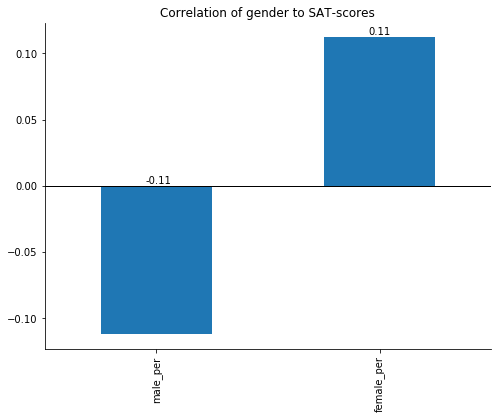

In [25]:
# build bar chart to visualize correlation between SAT and gender of students
gendr_corr = correlations.loc[['male_per', 'female_per']]['sat_score']
ax=gendr_corr.plot(kind='bar', figsize=(8, 6), title="Correlation of gender to SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for p in ax.patches: # set data point labels
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + 0.2, max(p.get_height(), 0)+0.002),
                rotation=0
                )
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

It appears that there is a weak correlation between each gender and SAT scores, positive one for female and negative for male students. That can be logical because female students generally prepare more responsible to the exams than man.

In [26]:
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='female_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["female_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share females, %',
        yTitle='Avg. SAT score',
        title='Share of female students vs. SAT score by school <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


There is no evident correlation on the above plot
- in all districts average `female_per` is about 50%, 
- schools with predomonation of female students: more than 60% and with higher SAT scores above 1400 are mainly from Manhattan and Queens districts.

In [21]:
combined.loc[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

# AP Exam Scores vs SAT Scores

In [22]:
# compute new feature: share of students that took Advanced Placement (AP) exams to earn college credit
combined['ap_per']=(combined['AP Test Takers ']/combined['total_enrollment'])*100
combined['ap_per'].head()

0   30.576
1    9.898
2    3.177
3   35.158
4   15.809
Name: ap_per, dtype: float64

In [27]:
# build scatter plot investigating correlation between share of AP-Test takers and SAT-score
with warnings.catch_warnings(): # to catch warning about np.module in Python 3.8.2.
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='ap_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["ap_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='AP-Test Takers, %',
        yTitle='Avg. SAT score',
        title='Share of AP-Test takers vs. SAT score by school <br> dashed lines: average of entire dataset'
    )
print("Recommendation: choose option to 'show closest data point on hover' in top right corner")

Recommendation: choose option to 'show closest data point on hover' in top right corner


Advanced Placement (AP) is a program in the United States and Canada created by the College Board which offers college-level curricula and examinations to high school students to earn college credit.

There is no general correlation between number of students who took at least one AP exam with school's SAT scores
- but it appears there is evident up trend for schools with higher SAT scores above 1400, 
- seems they are selective schools where AP takers percent is 50%-60% and students from these schools generally have above average academic aptitude and benefit more from academic placement than students in other schools.